In [1]:
import sys
import keras
import tensorflow as tf

print('python version:', sys.version)
print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


python version: 3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
keras version: 2.3.1
tensorflow version: 2.1.0


# 6.3 Advanced use of recurrent neural networks
---
## A temperature-forecasting problem

### Inspecting the data of the Jena weather dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parsing the data

In [3]:
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plotting the temperature timeseries

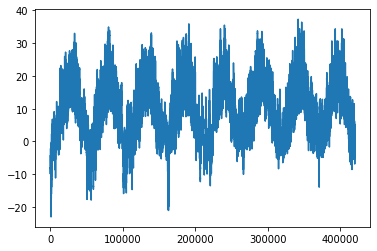

In [4]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

### Plotting the first 10 days of the temperature timeseries

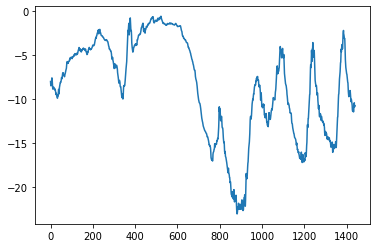

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

### Normalizing the data

In [6]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

### Generator yielding timeseries samples and their targets

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle = False, batch_size = 128, step = 6, revert = False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        if revert:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

### Preparing the training, validation and test generators

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size)

train_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

val_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

test_gen_r = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size,
                      revert = True)

# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size

# How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Computing the common-sense baseline MAE

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


### Training and evaluating a densely connected model

In [10]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 1.4729 - val_loss: 0.6716
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 0.5668 - val_loss: 0.2824
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3173 - val_loss: 0.2395
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2745 - val_loss: 0.2512
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2580 - val_loss: 0.2883
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2497 - val_loss: 0.2913
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2402 - val_loss: 0.3340
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2341 - val_loss: 0.3189
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2294 - val_loss: 0.2732
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2269 - val

### Plotting results

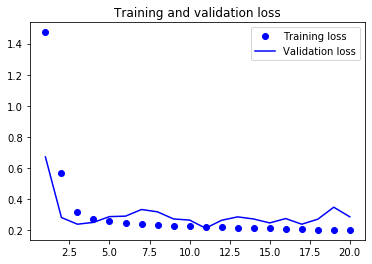

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a GRU-based model

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     implementation = 1,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2980 - val_loss: 0.3195
Epoch 2/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2847 - val_loss: 0.3473
Epoch 3/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2806 - val_loss: 0.3474
Epoch 4/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2742 - val_loss: 0.3503
Epoch 5/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2705 - val_loss: 0.3574
Epoch 6/20
500/500 [==============================] - 112s 223ms/step - loss: 0.2665 - val_loss: 0.3738
Epoch 7/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2604 - val_loss: 0.3774
Epoch 8/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2577 - val_loss: 0.3480
Epoch 9/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2547 - val_loss: 0.3596
Epoch 10/20
500/500 [==============================] - 112s 224m

### Plotting results

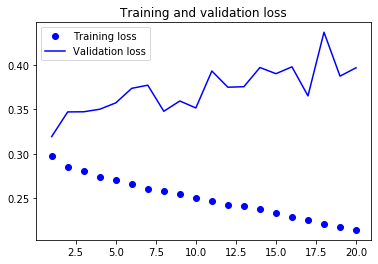

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a dropout-regularized GRU-based model

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    implementation = 1,
                    dropout = 0.2,
                    recurrent_dropout = 0.2,
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 132s 264ms/step - loss: 0.3396 - val_loss: 0.3607
Epoch 2/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3178 - val_loss: 0.3121
Epoch 3/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3120 - val_loss: 0.2772
Epoch 4/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3051 - val_loss: 0.2512
Epoch 5/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3011 - val_loss: 0.2310
Epoch 6/40
500/500 [==============================] - 130s 261ms/step - loss: 0.2984 - val_loss: 0.2308
Epoch 7/40
500/500 [==============================] - 131s 262ms/step - loss: 0.2973 - val_loss: 0.1925
Epoch 8/40
500/500 [==============================] - 131s 261ms/step - loss: 0.2957 - val_loss: 0.1910
Epoch 9/40
500/500 [==============================] - 132s 264ms/step - loss: 0.2916 - val_loss: 0.1659
Epoch 10/40
500/500 [==============================] - 132s 263m

### Plotting results

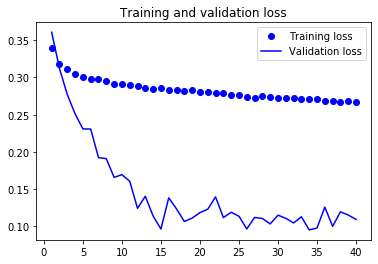

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating a dropout-regularized, stacked GRU model

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    implementation = 1,
                    dropout = 0.1,
                    recurrent_dropout = 0.5,
                    return_sequences = True,
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64,
                    implementation = 1,
                    activation = 'relu',
                    dropout = 0.1,
                    recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 272s 544ms/step - loss: 0.3343 - val_loss: 0.3196
Epoch 2/40
500/500 [==============================] - 270s 541ms/step - loss: 0.3115 - val_loss: 0.3645
Epoch 3/40
500/500 [==============================] - 270s 539ms/step - loss: 0.3066 - val_loss: 0.3743
Epoch 4/40
500/500 [==============================] - 271s 542ms/step - loss: 0.3014 - val_loss: 0.3528
Epoch 5/40
500/500 [==============================] - 271s 542ms/step - loss: 0.2982 - val_loss: 0.3656
Epoch 6/40
500/500 [==============================] - 269s 539ms/step - loss: 0.2951 - val_loss: 0.3426
Epoch 7/40
500/500 [==============================] - 270s 540ms/step - loss: 0.2934 - val_loss: 0.3331
Epoch 8/40
500/500 [==============================] - 269s 537ms/step - loss: 0.2910 - val_loss: 0.2878
Epoch 9/40
500/500 [==============================] - 268s 537ms/step - loss: 0.2875 - val_loss: 0.2180
Epoch 10/40
500/500 [==============================] - 269s 539m

### Plotting results

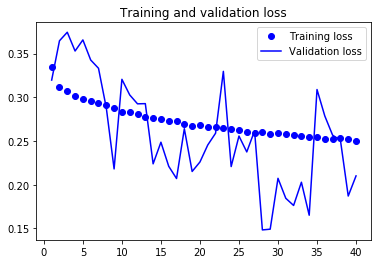

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating an GRU-based model using reversed sequences

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     implementation = 1,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen_r,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen_r,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 115s 229ms/step - loss: 0.4803 - val_loss: 0.1689
Epoch 2/20
500/500 [==============================] - 114s 228ms/step - loss: 0.4316 - val_loss: 0.1871
Epoch 3/20
500/500 [==============================] - 113s 226ms/step - loss: 0.3892 - val_loss: 0.2125
Epoch 4/20
500/500 [==============================] - 113s 226ms/step - loss: 0.3501 - val_loss: 0.3165
Epoch 5/20
500/500 [==============================] - 113s 225ms/step - loss: 0.3253 - val_loss: 0.3471
Epoch 6/20
500/500 [==============================] - 114s 227ms/step - loss: 0.3066 - val_loss: 0.2843
Epoch 7/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2954 - val_loss: 0.1967
Epoch 8/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2874 - val_loss: 0.1841
Epoch 9/20
500/500 [==============================] - 113s 225ms/step - loss: 0.2768 - val_loss: 0.1796
Epoch 10/20
500/500 [==============================] - 113s 226m

### Plotting results

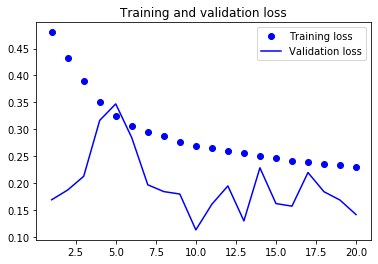

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Training and evaluating an LSTM using reversed sequences

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000 # Number of words to consider as features
maxlen = 500 # Cuts off texts after this number of words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

# Reverses sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pads sequences
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_split = 0.2)

C:\Users\alexa\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.4816 - acc: 0.7735 - val_loss: 0.3610 - val_acc: 0.8614
Epoch 2/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.3132 - acc: 0.8779 - val_loss: 0.3663 - val_acc: 0.8488
Epoch 3/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2514 - acc: 0.9057 - val_loss: 0.3495 - val_acc: 0.8496
Epoch 4/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2214 - acc: 0.9216 - val_loss: 0.6791 - val_acc: 0.7458
Epoch 5/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1896 - acc: 0.9324 - val_loss: 0.3764 - val_acc: 0.8804
Epoch 6/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1786 - acc: 0.9384 - val_loss: 0.3453 - val_acc: 0.8782
Epoch 7/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1512 - acc: 0.9480 - val_loss: 0.5031 - val_acc:

### Training and evaluating a bidirectional LSTM

In [22]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_split = 0.2)

C:\Users\alexa\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 104s 5ms/step - loss: 0.5609 - acc: 0.7175 - val_loss: 0.3889 - val_acc: 0.8352
Epoch 2/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.3370 - acc: 0.8684 - val_loss: 0.5914 - val_acc: 0.8032
Epoch 3/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.2667 - acc: 0.9012 - val_loss: 0.3053 - val_acc: 0.8752
Epoch 4/10
20000/20000 [==============================] - 101s 5ms/step - loss: 0.2312 - acc: 0.9172 - val_loss: 0.3482 - val_acc: 0.8696
Epoch 5/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.2071 - acc: 0.9292 - val_loss: 0.3409 - val_acc: 0.8624
Epoch 6/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.1900 - acc: 0.9354 - val_loss: 0.6294 - val_acc: 0.8414
Epoch 7/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.1663 - acc: 0.9430 - val_loss: 0.3922 - v

### Training a bidirectional GRU

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32, implementation = 1),
                               input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 226s 451ms/step - loss: 0.2954 - val_loss: 0.0823
Epoch 2/40
500/500 [==============================] - 224s 447ms/step - loss: 0.2741 - val_loss: 0.0969
Epoch 3/40
500/500 [==============================] - 223s 447ms/step - loss: 0.2685 - val_loss: 0.0955
Epoch 4/40
500/500 [==============================] - 226s 453ms/step - loss: 0.2635 - val_loss: 0.0743
Epoch 5/40
500/500 [==============================] - 226s 453ms/step - loss: 0.2587 - val_loss: 0.0794
Epoch 6/40
500/500 [==============================] - 228s 456ms/step - loss: 0.2536 - val_loss: 0.0699
Epoch 7/40
500/500 [==============================] - 226s 452ms/step - loss: 0.2475 - val_loss: 0.0770
Epoch 8/40
500/500 [==============================] - 228s 455ms/step - loss: 0.2396 - val_loss: 0.0718
Epoch 9/40
500/500 [==============================] - 230s 461ms/step - loss: 0.2344 - val_loss: 0.0793
Epoch 10/40
500/500 [==============================] - 223s 446m

### Plotting results

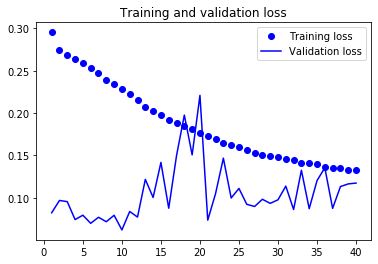

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()